<a href="https://colab.research.google.com/github/MASDXI/NF-846-Deep-Learning/blob/main/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches

# (It may complain that some files are missing because the files seem to have been
# reorganized on the underlying website, but it still seems to work). If everything is working
# properly, then the whole notebook should run to the end without further problems
# even before you make changes.
batch_size_train = 64
batch_size_test = 1000

# TODO Change this directory to point towards an existing directory
myDir = '/files/'

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.20MB/s]


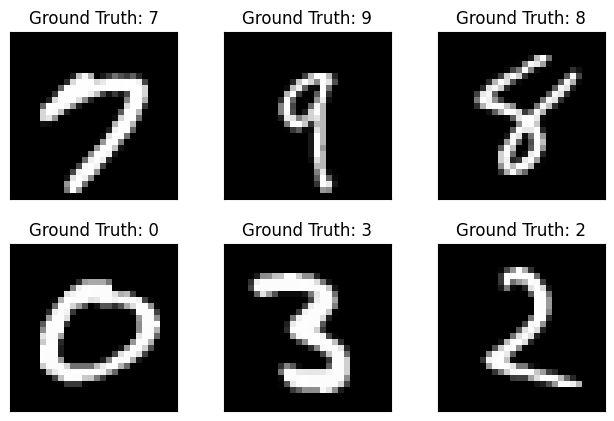

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [8]:
from os import X_OK
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Valid convolution, 1 channel in, 2 channels out, stride 1, kernel size = 3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        # Dropout for convolutions
        self.drop = nn.Dropout2d()
        # Fully connected layer
        self.fc1 = nn.Linear(338, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.log_softmax(x)
        return x






In [9]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [10]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [13]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [14]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [15]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.6460, Accuracy: 915/10000 (9%)

Train Epoch: 1 [0/60000]	Loss: 2.972960
Train Epoch: 1 [640/60000]	Loss: 2.319580
Train Epoch: 1 [1280/60000]	Loss: 2.182939


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [1920/60000]	Loss: 2.026715
Train Epoch: 1 [2560/60000]	Loss: 2.220032


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [3200/60000]	Loss: 1.929749
Train Epoch: 1 [3840/60000]	Loss: 1.838656
Train Epoch: 1 [4480/60000]	Loss: 1.495320
Train Epoch: 1 [5120/60000]	Loss: 1.510156
Train Epoch: 1 [5760/60000]	Loss: 1.392467


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [6400/60000]	Loss: 1.565693
Train Epoch: 1 [7040/60000]	Loss: 1.607844
Train Epoch: 1 [7680/60000]	Loss: 1.504403
Train Epoch: 1 [8320/60000]	Loss: 1.311713
Train Epoch: 1 [8960/60000]	Loss: 1.648627


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [9600/60000]	Loss: 1.378169
Train Epoch: 1 [10240/60000]	Loss: 1.024609
Train Epoch: 1 [10880/60000]	Loss: 1.424803
Train Epoch: 1 [11520/60000]	Loss: 1.395365


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [12160/60000]	Loss: 1.445313
Train Epoch: 1 [12800/60000]	Loss: 1.308862
Train Epoch: 1 [13440/60000]	Loss: 1.240634
Train Epoch: 1 [14080/60000]	Loss: 1.156107


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [14720/60000]	Loss: 1.184082
Train Epoch: 1 [15360/60000]	Loss: 1.207316
Train Epoch: 1 [16000/60000]	Loss: 1.081277
Train Epoch: 1 [16640/60000]	Loss: 1.094302
Train Epoch: 1 [17280/60000]	Loss: 1.064397
Train Epoch: 1 [17920/60000]	Loss: 1.239595
Train Epoch: 1 [18560/60000]	Loss: 1.280379
Train Epoch: 1 [19200/60000]	Loss: 1.192131
Train Epoch: 1 [19840/60000]	Loss: 1.058233
Train Epoch: 1 [20480/60000]	Loss: 0.925606


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [21120/60000]	Loss: 1.034431
Train Epoch: 1 [21760/60000]	Loss: 1.205049


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [22400/60000]	Loss: 1.252362
Train Epoch: 1 [23040/60000]	Loss: 0.992143
Train Epoch: 1 [23680/60000]	Loss: 1.068081
Train Epoch: 1 [24320/60000]	Loss: 0.697190
Train Epoch: 1 [24960/60000]	Loss: 1.230467
Train Epoch: 1 [25600/60000]	Loss: 0.825936
Train Epoch: 1 [26240/60000]	Loss: 0.865995
Train Epoch: 1 [26880/60000]	Loss: 1.253253


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [27520/60000]	Loss: 1.409234
Train Epoch: 1 [28160/60000]	Loss: 1.030010


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [28800/60000]	Loss: 0.857412
Train Epoch: 1 [29440/60000]	Loss: 0.895288
Train Epoch: 1 [30080/60000]	Loss: 0.878495
Train Epoch: 1 [30720/60000]	Loss: 0.766906
Train Epoch: 1 [31360/60000]	Loss: 0.953395


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [32000/60000]	Loss: 0.887610
Train Epoch: 1 [32640/60000]	Loss: 1.007297


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [33280/60000]	Loss: 1.242120


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [33920/60000]	Loss: 0.781623
Train Epoch: 1 [34560/60000]	Loss: 1.316739
Train Epoch: 1 [35200/60000]	Loss: 0.879329


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [35840/60000]	Loss: 1.034027


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [36480/60000]	Loss: 0.784281
Train Epoch: 1 [37120/60000]	Loss: 1.277366
Train Epoch: 1 [37760/60000]	Loss: 0.606921


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [38400/60000]	Loss: 0.756931
Train Epoch: 1 [39040/60000]	Loss: 0.432017
Train Epoch: 1 [39680/60000]	Loss: 1.074010
Train Epoch: 1 [40320/60000]	Loss: 0.903096
Train Epoch: 1 [40960/60000]	Loss: 0.846968


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [41600/60000]	Loss: 0.610911
Train Epoch: 1 [42240/60000]	Loss: 0.731873
Train Epoch: 1 [42880/60000]	Loss: 0.836367
Train Epoch: 1 [43520/60000]	Loss: 0.781161
Train Epoch: 1 [44160/60000]	Loss: 0.895093
Train Epoch: 1 [44800/60000]	Loss: 0.891677


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [45440/60000]	Loss: 1.134401
Train Epoch: 1 [46080/60000]	Loss: 0.882447
Train Epoch: 1 [46720/60000]	Loss: 0.902161
Train Epoch: 1 [47360/60000]	Loss: 0.892220


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [48000/60000]	Loss: 0.826790
Train Epoch: 1 [48640/60000]	Loss: 1.251444
Train Epoch: 1 [49280/60000]	Loss: 0.810697
Train Epoch: 1 [49920/60000]	Loss: 1.046345
Train Epoch: 1 [50560/60000]	Loss: 1.057683


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [51200/60000]	Loss: 1.080974
Train Epoch: 1 [51840/60000]	Loss: 0.897113
Train Epoch: 1 [52480/60000]	Loss: 0.720627
Train Epoch: 1 [53120/60000]	Loss: 0.850169
Train Epoch: 1 [53760/60000]	Loss: 0.736084
Train Epoch: 1 [54400/60000]	Loss: 0.807604


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [55040/60000]	Loss: 1.009773
Train Epoch: 1 [55680/60000]	Loss: 1.087788
Train Epoch: 1 [56320/60000]	Loss: 0.860911
Train Epoch: 1 [56960/60000]	Loss: 0.893264
Train Epoch: 1 [57600/60000]	Loss: 0.780132


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [58240/60000]	Loss: 0.727462
Train Epoch: 1 [58880/60000]	Loss: 0.955454
Train Epoch: 1 [59520/60000]	Loss: 1.130731


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8


Test set: Avg. loss: 0.3587, Accuracy: 9028/10000 (90%)

Train Epoch: 2 [0/60000]	Loss: 0.770405


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [640/60000]	Loss: 0.882094
Train Epoch: 2 [1280/60000]	Loss: 1.020015
Train Epoch: 2 [1920/60000]	Loss: 1.001433
Train Epoch: 2 [2560/60000]	Loss: 0.868761
Train Epoch: 2 [3200/60000]	Loss: 0.967548
Train Epoch: 2 [3840/60000]	Loss: 0.923372
Train Epoch: 2 [4480/60000]	Loss: 1.004852
Train Epoch: 2 [5120/60000]	Loss: 0.865758


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [5760/60000]	Loss: 0.996503
Train Epoch: 2 [6400/60000]	Loss: 0.811080


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [7040/60000]	Loss: 1.009212
Train Epoch: 2 [7680/60000]	Loss: 1.179332
Train Epoch: 2 [8320/60000]	Loss: 0.716913
Train Epoch: 2 [8960/60000]	Loss: 1.069445
Train Epoch: 2 [9600/60000]	Loss: 0.828547


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [10240/60000]	Loss: 0.980560
Train Epoch: 2 [10880/60000]	Loss: 0.838564
Train Epoch: 2 [11520/60000]	Loss: 0.809389
Train Epoch: 2 [12160/60000]	Loss: 0.935626
Train Epoch: 2 [12800/60000]	Loss: 0.662665
Train Epoch: 2 [13440/60000]	Loss: 0.728664
Train Epoch: 2 [14080/60000]	Loss: 0.943179
Train Epoch: 2 [14720/60000]	Loss: 0.939074
Train Epoch: 2 [15360/60000]	Loss: 1.013667


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [16000/60000]	Loss: 1.069479


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [16640/60000]	Loss: 0.725219
Train Epoch: 2 [17280/60000]	Loss: 0.902498
Train Epoch: 2 [17920/60000]	Loss: 0.956478
Train Epoch: 2 [18560/60000]	Loss: 0.833954
Train Epoch: 2 [19200/60000]	Loss: 1.004178


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [19840/60000]	Loss: 0.886304
Train Epoch: 2 [20480/60000]	Loss: 1.135451
Train Epoch: 2 [21120/60000]	Loss: 0.917220
Train Epoch: 2 [21760/60000]	Loss: 0.948633
Train Epoch: 2 [22400/60000]	Loss: 0.973406
Train Epoch: 2 [23040/60000]	Loss: 0.984467


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [23680/60000]	Loss: 1.130440
Train Epoch: 2 [24320/60000]	Loss: 0.730764
Train Epoch: 2 [24960/60000]	Loss: 0.727745
Train Epoch: 2 [25600/60000]	Loss: 0.925080


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [26240/60000]	Loss: 0.911501
Train Epoch: 2 [26880/60000]	Loss: 0.700662
Train Epoch: 2 [27520/60000]	Loss: 0.748305
Train Epoch: 2 [28160/60000]	Loss: 0.608069
Train Epoch: 2 [28800/60000]	Loss: 0.929443


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [29440/60000]	Loss: 0.788952
Train Epoch: 2 [30080/60000]	Loss: 0.739866
Train Epoch: 2 [30720/60000]	Loss: 0.881520
Train Epoch: 2 [31360/60000]	Loss: 0.766200
Train Epoch: 2 [32000/60000]	Loss: 0.896208
Train Epoch: 2 [32640/60000]	Loss: 0.770983
Train Epoch: 2 [33280/60000]	Loss: 0.996667
Train Epoch: 2 [33920/60000]	Loss: 0.671137


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [34560/60000]	Loss: 0.677703


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [35200/60000]	Loss: 0.910486
Train Epoch: 2 [35840/60000]	Loss: 1.025198
Train Epoch: 2 [36480/60000]	Loss: 0.859403


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [37120/60000]	Loss: 0.857758
Train Epoch: 2 [37760/60000]	Loss: 0.790459
Train Epoch: 2 [38400/60000]	Loss: 0.902215
Train Epoch: 2 [39040/60000]	Loss: 0.905455
Train Epoch: 2 [39680/60000]	Loss: 0.865312
Train Epoch: 2 [40320/60000]	Loss: 0.887854
Train Epoch: 2 [40960/60000]	Loss: 0.768353
Train Epoch: 2 [41600/60000]	Loss: 0.802332
Train Epoch: 2 [42240/60000]	Loss: 0.899253


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [42880/60000]	Loss: 0.823116
Train Epoch: 2 [43520/60000]	Loss: 0.608874
Train Epoch: 2 [44160/60000]	Loss: 0.788249
Train Epoch: 2 [44800/60000]	Loss: 0.703049
Train Epoch: 2 [45440/60000]	Loss: 0.850035


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [46080/60000]	Loss: 0.796633
Train Epoch: 2 [46720/60000]	Loss: 0.880445
Train Epoch: 2 [47360/60000]	Loss: 0.894998
Train Epoch: 2 [48000/60000]	Loss: 0.703733
Train Epoch: 2 [48640/60000]	Loss: 0.697174
Train Epoch: 2 [49280/60000]	Loss: 0.906089
Train Epoch: 2 [49920/60000]	Loss: 0.704504
Train Epoch: 2 [50560/60000]	Loss: 0.860448
Train Epoch: 2 [51200/60000]	Loss: 1.139420


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [51840/60000]	Loss: 0.834159
Train Epoch: 2 [52480/60000]	Loss: 0.861920
Train Epoch: 2 [53120/60000]	Loss: 0.811219
Train Epoch: 2 [53760/60000]	Loss: 0.695547


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [54400/60000]	Loss: 1.015781
Train Epoch: 2 [55040/60000]	Loss: 0.930183


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 2 [55680/60000]	Loss: 0.638751
Train Epoch: 2 [56320/60000]	Loss: 0.767860
Train Epoch: 2 [56960/60000]	Loss: 0.721728
Train Epoch: 2 [57600/60000]	Loss: 0.873067
Train Epoch: 2 [58240/60000]	Loss: 0.691665
Train Epoch: 2 [58880/60000]	Loss: 0.754814
Train Epoch: 2 [59520/60000]	Loss: 0.674450


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-pack


Test set: Avg. loss: 0.3240, Accuracy: 9094/10000 (91%)

Train Epoch: 3 [0/60000]	Loss: 0.890220
Train Epoch: 3 [640/60000]	Loss: 0.844367
Train Epoch: 3 [1280/60000]	Loss: 0.787862
Train Epoch: 3 [1920/60000]	Loss: 0.935889
Train Epoch: 3 [2560/60000]	Loss: 0.881958
Train Epoch: 3 [3200/60000]	Loss: 0.622617
Train Epoch: 3 [3840/60000]	Loss: 1.009119


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [4480/60000]	Loss: 0.930434
Train Epoch: 3 [5120/60000]	Loss: 0.818387


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [5760/60000]	Loss: 1.222380
Train Epoch: 3 [6400/60000]	Loss: 0.751656
Train Epoch: 3 [7040/60000]	Loss: 0.772235


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [7680/60000]	Loss: 0.929369
Train Epoch: 3 [8320/60000]	Loss: 0.890309
Train Epoch: 3 [8960/60000]	Loss: 0.801984
Train Epoch: 3 [9600/60000]	Loss: 0.829728
Train Epoch: 3 [10240/60000]	Loss: 0.829449
Train Epoch: 3 [10880/60000]	Loss: 0.803920
Train Epoch: 3 [11520/60000]	Loss: 0.714975
Train Epoch: 3 [12160/60000]	Loss: 0.718302


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [12800/60000]	Loss: 0.890312


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [13440/60000]	Loss: 0.859512
Train Epoch: 3 [14080/60000]	Loss: 0.751558
Train Epoch: 3 [14720/60000]	Loss: 1.095695
Train Epoch: 3 [15360/60000]	Loss: 1.129446
Train Epoch: 3 [16000/60000]	Loss: 0.783627


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [16640/60000]	Loss: 0.938225
Train Epoch: 3 [17280/60000]	Loss: 0.880519
Train Epoch: 3 [17920/60000]	Loss: 0.629901
Train Epoch: 3 [18560/60000]	Loss: 0.828489
Train Epoch: 3 [19200/60000]	Loss: 0.798738
Train Epoch: 3 [19840/60000]	Loss: 0.691797
Train Epoch: 3 [20480/60000]	Loss: 0.873068
Train Epoch: 3 [21120/60000]	Loss: 0.892148


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [21760/60000]	Loss: 1.108686
Train Epoch: 3 [22400/60000]	Loss: 0.759301


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [23040/60000]	Loss: 0.717421
Train Epoch: 3 [23680/60000]	Loss: 0.870833
Train Epoch: 3 [24320/60000]	Loss: 0.889541
Train Epoch: 3 [24960/60000]	Loss: 0.461379


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [25600/60000]	Loss: 1.009430
Train Epoch: 3 [26240/60000]	Loss: 0.678664
Train Epoch: 3 [26880/60000]	Loss: 0.742059
Train Epoch: 3 [27520/60000]	Loss: 0.713715
Train Epoch: 3 [28160/60000]	Loss: 0.583229
Train Epoch: 3 [28800/60000]	Loss: 0.795568
Train Epoch: 3 [29440/60000]	Loss: 0.751313
Train Epoch: 3 [30080/60000]	Loss: 0.978872
Train Epoch: 3 [30720/60000]	Loss: 0.968913


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [31360/60000]	Loss: 0.398630


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [32000/60000]	Loss: 0.785651
Train Epoch: 3 [32640/60000]	Loss: 0.708460
Train Epoch: 3 [33280/60000]	Loss: 0.702438
Train Epoch: 3 [33920/60000]	Loss: 0.932430


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [34560/60000]	Loss: 0.741596
Train Epoch: 3 [35200/60000]	Loss: 0.877965
Train Epoch: 3 [35840/60000]	Loss: 0.827555
Train Epoch: 3 [36480/60000]	Loss: 0.683451
Train Epoch: 3 [37120/60000]	Loss: 0.990118


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [37760/60000]	Loss: 0.639798
Train Epoch: 3 [38400/60000]	Loss: 0.813751
Train Epoch: 3 [39040/60000]	Loss: 0.948313
Train Epoch: 3 [39680/60000]	Loss: 0.773821
Train Epoch: 3 [40320/60000]	Loss: 1.006445
Train Epoch: 3 [40960/60000]	Loss: 0.852829


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [41600/60000]	Loss: 1.079090
Train Epoch: 3 [42240/60000]	Loss: 0.552037
Train Epoch: 3 [42880/60000]	Loss: 0.817837


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [43520/60000]	Loss: 0.903971
Train Epoch: 3 [44160/60000]	Loss: 0.787516
Train Epoch: 3 [44800/60000]	Loss: 0.749015
Train Epoch: 3 [45440/60000]	Loss: 0.925525
Train Epoch: 3 [46080/60000]	Loss: 0.970309
Train Epoch: 3 [46720/60000]	Loss: 0.902749
Train Epoch: 3 [47360/60000]	Loss: 0.768127


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [48000/60000]	Loss: 0.914702


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [48640/60000]	Loss: 0.803172
Train Epoch: 3 [49280/60000]	Loss: 0.731773
Train Epoch: 3 [49920/60000]	Loss: 0.684157
Train Epoch: 3 [50560/60000]	Loss: 0.883716
Train Epoch: 3 [51200/60000]	Loss: 1.232603


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [51840/60000]	Loss: 0.737346
Train Epoch: 3 [52480/60000]	Loss: 0.767148
Train Epoch: 3 [53120/60000]	Loss: 0.666706
Train Epoch: 3 [53760/60000]	Loss: 0.969822
Train Epoch: 3 [54400/60000]	Loss: 0.854937
Train Epoch: 3 [55040/60000]	Loss: 0.817218
Train Epoch: 3 [55680/60000]	Loss: 0.781144
Train Epoch: 3 [56320/60000]	Loss: 1.078197
Train Epoch: 3 [56960/60000]	Loss: 0.912293


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [57600/60000]	Loss: 0.992497


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 3 [58240/60000]	Loss: 0.844637
Train Epoch: 3 [58880/60000]	Loss: 0.937225
Train Epoch: 3 [59520/60000]	Loss: 0.605143


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3120, Accuracy: 9133/10000 (91%)



/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


/tmp/ipython-input-8-2166679198.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


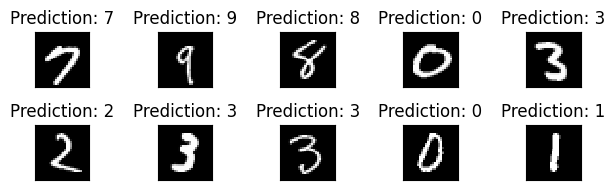

In [16]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()